In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
data.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


Going down the checklist of things to check for:
- Missing/duplicate values
- Data Types
- target variable distribution
- outliers

In [23]:
# Check missing vals
data.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [25]:
# Check duplicate values
data.duplicated().sum()

0

In [28]:
# check for outliers in feature values
data.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


Age and Calories appear pretty skewed

Check distribution of target variable -- Calories

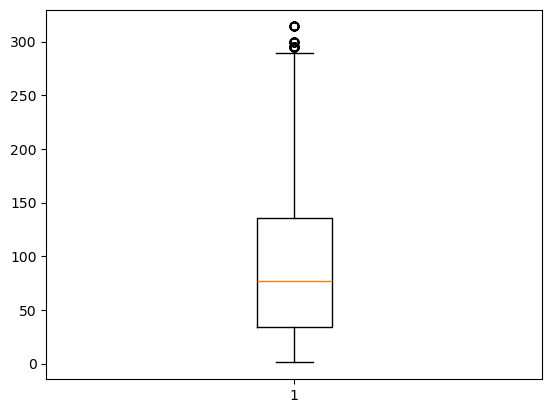

In [3]:
plt.boxplot(data['Calories'])
plt.show()

Check outliers

In [19]:
iqr_q3 = np.quantile(data['Calories'], 0.75) + 1.5*np.diff(np.quantile(data['Calories'], [0.25, 0.75])).item()
data[data['Calories'] > iqr_q3]

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
10378,10378,male,75,180.0,79.0,30.0,120.0,41.2,295.0
10730,10730,male,60,205.0,114.0,30.0,119.0,40.8,295.0
14209,14209,male,64,185.0,90.0,29.0,127.0,40.9,295.0
19879,19879,male,72,186.0,93.0,30.0,125.0,41.0,295.0
20288,20288,male,75,178.0,76.0,29.0,120.0,40.9,295.0
...,...,...,...,...,...,...,...,...,...
715444,715444,male,72,191.0,97.0,28.0,120.0,40.9,295.0
716858,716858,male,70,182.0,86.0,29.0,120.0,40.9,295.0
718029,718029,male,33,198.0,96.0,29.0,121.0,40.9,300.0
732529,732529,male,57,195.0,97.0,29.0,120.0,41.1,314.0


Target variable is pretty right-skewed with a lot of high-value outliers.

Check distribution of male vs. female subjects.
And see if there's any relation with the target variable.

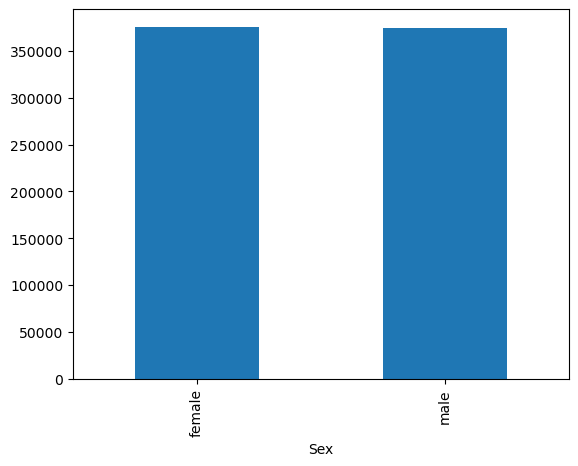

In [30]:
plt.figure()
data['Sex'].value_counts().plot.bar()
plt.show()

Counts appear identical.

In [34]:
data.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'],
      dtype='object')

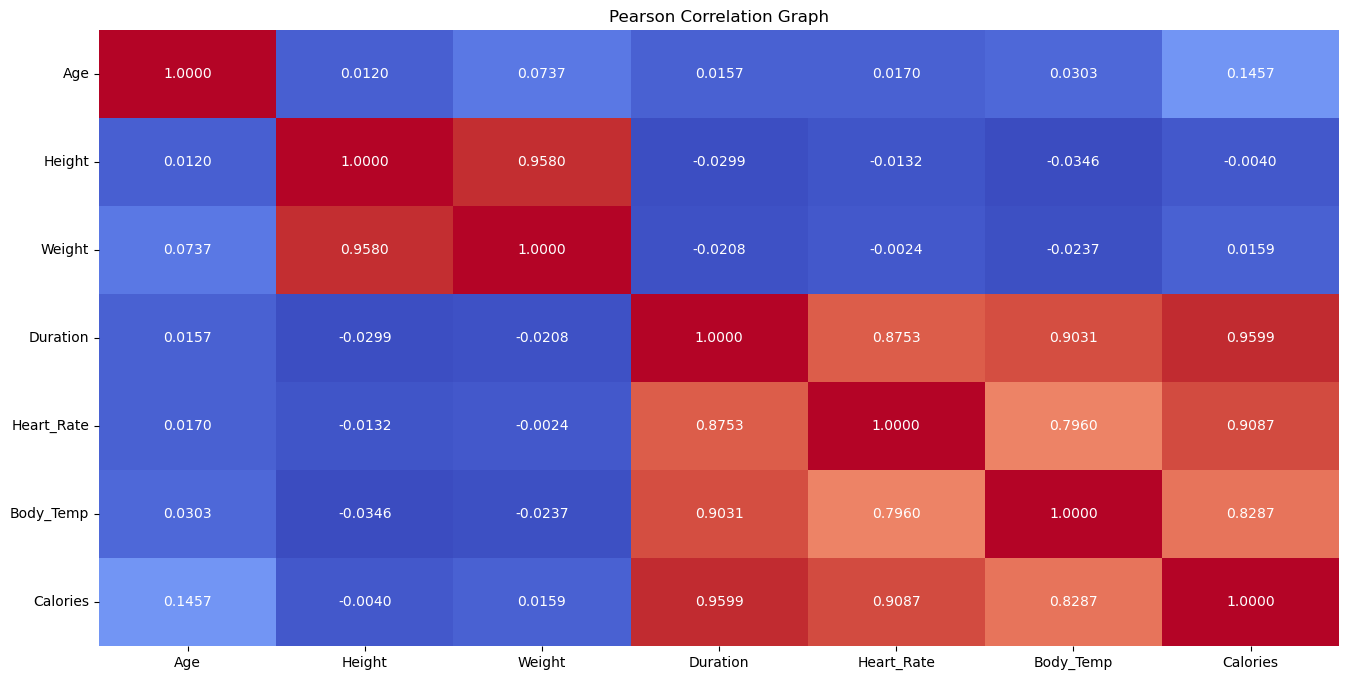

In [36]:
#Check correlations
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
data_num = data.drop(['id', 'Sex'], axis=1)
fig, ax = plt.subplots(figsize = (16,8))
sns.heatmap(data_num.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.set_title("Pearson Correlation Graph")
plt.show()

High correlation between Duration and Heart Rate, Body Temp, and Calories. Perhaps we can consider removing some of these variables, or consider different regularization techniques.

In [10]:
# Splitting into Train and val
from sklearn.model_selection import train_test_split
X = data.drop(['id','Calories'], axis = 1)
y = data['Calories']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.6, )
#test

Preprocessing

- Drop ID
- MinMax all other variables since they have a fairly contained range of values
- Convert Sex to binary values

In [11]:
from sklearn.preprocessing import FunctionTransformer
def convert_binary(inputs: np.ndarray):
    """
    Converts "male" and "female" to 1 and 0 values respectively.

    Parameters
    ----------
    inputs : np.ndarray
        Pandas column for 'Sex'

    Returns
    -------
    np.ndarray
        A Numpy array of containing binary values.
        """
    return np.where(inputs == 'male', 1, 0)

In [ ]:
def convert_binary(inputs: np.ndarray):
    """
    Converts 'male' to 1, 'female' to 0. Fills others with np.nan and warns.
    """
    mask_male = inputs == 'male'
    mask_female = inputs == 'female'
    result = np.full_like(inputs, np.nan, dtype=np.float64)
    result[mask_male] = 1
    result[mask_female] = 0

    # Print or log unexpected values
    if not np.all(mask_male | mask_female):
        unexpected = np.unique(inputs[~(mask_male | mask_female)])
        print(f'unexpected binary values encountered: {unexpected}')

    return result

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn import set_config
from sklearn.model_selection import KFold

#set_config(transform_output="pandas")

#std_ftrs = ['Calories']
minmax_ftrs = X.columns.drop(['Sex'])
binary_ftrs = ['Sex']


binary_transformer = FunctionTransformer(convert_binary)

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('binary', binary_transformer, binary_ftrs)
        ],
        remainder = 'passthrough'
)
# standardize all features after preprocessing
prep = Pipeline(steps = [('preprocessor', preprocessor)
                         , ('std', StandardScaler())
                         ])

X_train_prep = prep.fit_transform(X_train)
print(X_train_prep[:5])
print(X_train_prep.shape)


[[-0.95098956  1.42703213  1.27660424  0.9080786   0.79616936  0.85212759
   1.00307138]
 [-1.28048469 -0.21015825 -0.01028206  0.66861306  0.0552025   0.85212759
   1.00307138]
 [-0.02840321 -0.98977271 -1.01119363 -1.12737848 -0.79161677 -0.81642477
  -0.99693802]
 [-0.48969639  0.17964899 -0.36775048 -1.24711125 -0.89746917 -1.20147531
  -0.99693802]
 [ 1.28957729  0.95926345  0.77614846  0.9080786   1.3254314   0.59542723
   1.00307138]]
(450000, 7)


Evaluation Metric
We will be using Root Mean Squared Logarithmic Error (RMSLE) as our evaluation metric, as specific by the competition rules.

We'll consider the following ML algorithms:
- Linear Regression/Generalized Linear Models
- KNN
- XGBoost
- SVM
- Random Forests

In [65]:
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error, r2_score, mean_squared_error, make_scorer, mean_squared_log_error
def safe_rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
        return np.nan
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(safe_rmsle, greater_is_better=False)

In [66]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, GammaRegressor, HuberRegressor
from sklearn.model_selection import GridSearchCV
import time
# Linear Regression for a baseline
# Gamma regressor because we see a right-skewed target variable
# HuberRegressor as a form of robust regression, given our large number of outliers.

nr_states = 5
final_models = []

for i in range(nr_states):
    print(f"Random State: {i}")

    kf = KFold(n_splits = 6, random_state = i, shuffle = True)
    models = [
        LinearRegression(n_jobs = 1, positive=True),
        Ridge(random_state=i, solver = 'saga', max_iter = 1000000),
        Lasso(random_state=i, max_iter = 1000000, warm_start=True),
        ElasticNet(random_state=i, max_iter = 1000000, warm_start=True
                   , tol = 1e-3, selection = 'random'), # this is taking TOO long to run
        GammaRegressor(solver = 'newton-cholesky', max_iter = 1000000), # newton-cholesky since n_samples >> n_features
        HuberRegressor(max_iter = 1000000, warm_start=True)
    ]
    param_list = [
        { # Linear Regression
            # There's really nothing to configure tbh
        },
        { # Ridge
            'model__alpha': np.logspace(2,4,13)
        },
        { # Lasso
            'model__alpha': np.logspace(-1,3,13)
        },
        { # ElasticNet
            'model__alpha': np.logspace(-2,2,13),
            'model__l1_ratio': np.linspace(0,1,9)
            #'model__alpha': np.logspace(-2,2,5)
            #'model__l1_ratio': np.linspace(0,1,5)


        },
        { # Gamma Regressor
            'model__alpha': np.logspace(-3,1,13)
        },
        {# HuberRegressor
            'model__alpha': np.logspace(-5,3,17),
            'model__epsilon': np.linspace(1,4.15,10)
        }
    ]
    for j in range(len(models)):
        start_time = time.time()
        print(f"\nModel {models[j]}")
        reg = Pipeline(steps=[
            ('preprocessor', preprocessor)
            , ('std', StandardScaler())
            , ('model', models[j])
        ])
        grid = GridSearchCV(estimator = reg
                            , param_grid = param_list[j]
                            , scoring = rmsle_scorer
                            , cv = kf
                            , return_train_score=True
                            , n_jobs = -3)
        grid.fit(X = X_train, y = y_train)
        y_val_pred = grid.predict(X_val)
        print(f"Minimum prediction: {np.min(y_val_pred)}")
        y_val_pred = np.array([x if x >= 0 else 0 for x in y_val_pred])

        current_rmsle = root_mean_squared_log_error(y_val, y_val_pred)
        current_rmse = root_mean_squared_error(y_val, y_val_pred)
        current_r2 = r2_score(y_val, y_val_pred)

        final_models.append({
            'random_state': i,
            'grid': grid,
            'model': grid.best_estimator_['model'],
            'model_string': grid.best_estimator_['model'].__class__.__name__,
            'val_score': grid.best_score_,
            'val_rmsle': current_rmsle,
            'val_rmse': current_rmse,
            'val_r2': current_r2
        })

        print('best model parameters: ', grid.best_params_)
        print('validation score: ', grid.best_score_)
        print('RMSLE: ', current_rmsle)
        print('RMSE: ', current_rmse)
        print('R2: ', current_r2)
        print(f"Model Total Runtime: {round(time.time() - start_time, 3)}")
    models_df = pd.DataFrame(final_models)


Random State: 0

Model LinearRegression(n_jobs=1, positive=True)
Minimum prediction: -54.704031539705895
best model parameters:  {}
validation score:  -0.6459707493686692
RMSLE:  0.6434311575806325
RMSE:  11.492103288911059
R2:  0.9661039185083696
Model Total Runtime: 2.967

Model Ridge(max_iter=1000000, random_state=0, solver='saga')
Minimum prediction: -47.02178938671899
best model parameters:  {'model__alpha': 1000.0}
validation score:  -0.5655931134374065
RMSLE:  0.561880841890742
RMSE:  10.617598769757766
R2:  0.9710663600309027
Model Total Runtime: 13.216

Model Lasso(max_iter=1000000, random_state=0, warm_start=True)
Minimum prediction: -17.246371252794603
best model parameters:  {'model__alpha': 10.0}
validation score:  -0.3013091885888537
RMSLE:  0.3032791397403592
RMSE:  18.284562467304042
R2:  0.9141936163567339
Model Total Runtime: 3.328

Model ElasticNet(max_iter=1000000, random_state=0, selection='random', tol=0.001,
           warm_start=True)
Minimum prediction: -17.146

In [67]:
subset_size=0.35
int(np.ceil(subset_size*len(X_train)))

157500

In [68]:
# Dedicate one single cell to SVR since I expect it'll take a while
from sklearn.svm import SVR, LinearSVR
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearnex import patch_sklearn
patch_sklearn()
nr_states = 3
svc_models = []

n_estimators = 10

# subset the data because it's too big
subset_size = 0.35
n_samples=int(np.ceil(subset_size*len(X_train)))
X_small, y_small = resample(X_train, y_train, n_samples=n_samples, random_state=42)

for i in range(nr_states):
    print(f"Random State: {i}")

    kf = KFold(n_splits = 6, random_state = i, shuffle = True)
    models = [
        LinearSVR(random_state = i),
        SVR()
    ]
    param_list = [
        { # Linear SVR
            'model__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
            'model__C': np.logspace(-3,3,num=7),
        },
        { #SVR
            'model__kernel': ['rbf'],
            'model__C': np.logspace(-2,2,num=5),
            'model__gamma': ['scale']
        }
    ]
    for j in range(len(models)):
        start_time = time.time()
        print(f"\nModel {models[j]}")
        reg = Pipeline(steps=[
            ('preprocessor', preprocessor)
            , ('std', StandardScaler())
            , ('model', models[j])
        ])
        grid = RandomizedSearchCV(estimator = reg
                            , param_distributions= param_list[j]
                            , scoring = rmsle_scorer
                            , n_iter = 15
                            , cv = kf
                            , return_train_score=True
                            , n_jobs = -4)
        grid.fit(X = X_small, y = y_small)
        y_val_pred = grid.predict(X_val)
        print(f"Minimum prediction: {np.min(y_val_pred)}")
        y_val_pred = np.maximum(y_val_pred, 0)

        current_rmsle = root_mean_squared_log_error(y_val, y_val_pred)
        current_rmse = root_mean_squared_error(y_val, y_val_pred)
        current_r2 = r2_score(y_val, y_val_pred)

        svc_models.append({
            'random_state': i,
            'grid': grid,
            'model': grid.best_estimator_['model'],
            'model_string': grid.best_estimator_['model'].__class__.__name__,
            'val_score': grid.best_score_,
            'val_rmsle': current_rmsle,
            'val_rmse': current_rmse,
            'val_r2': current_r2
        })

        print('best model parameters: ', grid.best_params_)
        print('validation score: ', grid.best_score_)
        print('RMSLE: ', current_rmsle)
        print('RMSE: ', current_rmse)
        print('R2: ', current_r2)
        print(f"Model Total Runtime: {round(time.time() - start_time, 3)}")
    svm_models_df = pd.DataFrame(svc_models)


Random State: 0

Model LinearSVR(random_state=0)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=15. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Minimum prediction: -39.62835316270497
best model parameters:  {'model__loss': 'epsilon_insensitive', 'model__C': 10.0}
validation score:  -0.5129024756516384
RMSLE:  0.5084805943335796
RMSE:  11.306026107411403
R2:  0.9671927051583697
Model Total Runtime: 25.186

Model SVR()


c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=15. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Minimum prediction: 0.6421096377751105
best model parameters:  {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 100.0}
validation score:  -0.061872542311869456
RMSLE:  0.06043609185584758
RMSE:  3.6056875712290974
R2:  0.9966632271782571
Model Total Runtime: 1732.282
Random State: 1

Model LinearSVR(random_state=1)


c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=15. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=15. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Minimum prediction: -37.279731636377036
best model parameters:  {'model__loss': 'epsilon_insensitive', 'model__C': 1000.0}
validation score:  -0.46292854113521825
RMSLE:  0.520397666472312
RMSE:  13.042500186026448
R2:  0.9563411635770181
Model Total Runtime: 35.13

Model SVR()
Minimum prediction: 0.6421096377751105
best model parameters:  {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 100.0}
validation score:  -0.061833543484671925
RMSLE:  0.06043609185584758
RMSE:  3.6056875712290974
R2:  0.9966632271782571
Model Total Runtime: 1367.813
Random State: 2

Model LinearSVR(random_state=2)


c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=15. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Minimum prediction: -39.73406419817137
best model parameters:  {'model__loss': 'epsilon_insensitive', 'model__C': 10.0}
validation score:  -0.5146094091987874
RMSLE:  0.5087621401375962
RMSE:  11.28503543778986
R2:  0.9673144115497345
Model Total Runtime: 30.836

Model SVR()


c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=15. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Minimum prediction: 0.6421096377751105
best model parameters:  {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 100.0}
validation score:  -0.06176641236089314
RMSLE:  0.06043609185584758
RMSE:  3.6056875712290974
R2:  0.9966632271782571
Model Total Runtime: 1536.881


In [69]:
# Dedicate one single cell to SVR since I expect it'll take a while
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import BaggingRegressor
patch_sklearn()
# Trying BaggingClassifier for the non linear SVR

nr_states = 3
svc_models = []

n_estimators = 10

subset_size = 0.35
n_samples=int(np.ceil(subset_size*len(X_train)))
X_small, y_small = resample(X_train, y_train, n_samples=n_samples, random_state=42)

for i in range(nr_states):
    print(f"Random State: {i}")

    kf = KFold(n_splits = 6, random_state = i, shuffle = True)
    models = [
        BaggingRegressor(estimator = SVR(), max_samples = 1.0 / n_estimators, n_estimators = n_estimators)
    ]
    param_list = [
        { # bagged SVR
            'model__estimator__kernel': ['rbf'],
            'model__estimator__C': np.logspace(-2,2,num=5),
            'model__estimator__gamma': ['scale']
        }
    ]
    for j in range(len(models)):
        start_time = time.time()
        print(f"\nModel {models[j]}")
        reg = Pipeline(steps=[
            ('preprocessor', preprocessor)
            , ('std', StandardScaler())
            , ('model', models[j])
        ])
        grid = GridSearchCV(estimator = reg
                            , param_grid = param_list[j]
                            , scoring = rmsle_scorer
                            , cv = kf
                            , return_train_score=True
                            , n_jobs = -3)
        grid.fit(X = X_small, y = y_small)
        y_val_pred = grid.predict(X_val)
        print(f"Minimum prediction: {np.min(y_val_pred)}")
        y_val_pred = np.array([x if x >= 0 else 0 for x in y_val_pred])

        current_rmsle = root_mean_squared_log_error(y_val, y_val_pred)
        current_rmse = root_mean_squared_error(y_val, y_val_pred)
        current_r2 = r2_score(y_val, y_val_pred)

        svc_models.append({
            'random_state': i,
            'grid': grid,
            'model': grid.best_estimator_['model'],
            'model_string': grid.best_estimator_['model'].__class__.__name__,
            'val_score': grid.best_score_,
            'val_rmsle': current_rmsle,
            'val_rmse': current_rmse,
            'val_r2': current_r2
        })

        print('best model parameters: ', grid.best_params_)
        print('validation score: ', grid.best_score_)
        print('RMSLE: ', current_rmsle)
        print('RMSE: ', current_rmse)
        print('R2: ', current_r2)
        print(f"Model Total Runtime: {round(time.time() - start_time, 3)}")
    svm_bagged_models_df = pd.DataFrame(svc_models)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Random State: 0

Model BaggingRegressor(estimator=SVR(), max_samples=0.1)
Minimum prediction: 0.9730488276366025
best model parameters:  {'model__estimator__C': 100.0, 'model__estimator__gamma': 'scale', 'model__estimator__kernel': 'rbf'}
validation score:  -0.06435969319294758
RMSLE:  0.062471326436097714
RMSE:  3.6596155434509847
R2:  0.996562668795001
Model Total Runtime: 1228.287
Random State: 1

Model BaggingRegressor(estimator=SVR(), max_samples=0.1)
Minimum prediction: 1.1016175213265398
best model parameters:  {'model__estimator__C': 100.0, 'model__estimator__gamma': 'scale', 'model__estimator__kernel': 'rbf'}
validation score:  -0.06437983320255478
RMSLE:  0.06242318950732955
RMSE:  3.6529007169277805
R2:  0.9965752711612159
Model Total Runtime: 1412.048
Random State: 2

Model BaggingRegressor(estimator=SVR(), max_samples=0.1)
Minimum prediction: 0.916858655589936
best model parameters:  {'model__estimator__C': 100.0, 'model__estimator__gamma': 'scale', 'model__estimator__kern

In [70]:
# And now for other nonlinear/tree based models
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestRegressor

nr_states = 3
xgb_test_scores = np.zeros(nr_states)
tree_models = []
early_stopping_rounds = 50
early_stop = EarlyStopping(rounds=early_stopping_rounds, save_best=True)

for i in range(nr_states):
    print(f"Random State {i}")
    
    kf = KFold(n_splits = 6, random_state = i, shuffle = True)
    # 2nd split - splitting trainval into training and validation sets
    models = [
        KNeighborsRegressor(),
        RandomForestRegressor(random_state=i),
        XGBRegressor()#early_stopping_rounds = early_stopping_rounds)
        
    ]
    # and our lists of parameters, GridSearchCV will loop through all combos
    param_list = [
        { #KNN
            'model__n_neighbors': [1, 3, 5, 10, 20, 30],
            'model__weights': ['uniform','distance',None],
            'model__p':[1,2,5]
        },
        { #RandomForest
            'model__max_depth': [1, 3, 5, 10], # the max_depth should be smaller or equal than the number of features roughly
            'model__max_features': ['sqrt', 'log2', 0.3, 0.5], # linearly spaced between 0.5 and 1
            'model__criterion':['squared_error', 'friedman_mse', 'poisson']
        },
        { #XGBoost
            #'model__eval_set':[(X_val, y_val)],
            'model__learning_rate': [0.1],
            'model__max_depth': [1, 3, 5, 10],
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.5, 0.6, 1.0],
            'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
            'model__reg_lambda': [0, 0.01, 0.1, 1, 10]
        }
    ]
    # for each Model...
    # Create a new Pipeline with our previous ColumnTransformer + new model
    for j in range(len(models)):
        start_time = time.time()
        print(f"\nModel {models[j]}")
        reg = Pipeline(steps=[
            ('preprocessor', preprocessor)
            , ('std', StandardScaler())
            , ('model', models[j])
        ])
        grid = GridSearchCV(estimator = reg
                            , param_grid = param_list[j]
                            , scoring = rmsle_scorer
                            , cv = kf
                            , return_train_score=True
                            , n_jobs = -3)
        grid.fit(X = X_small, y = y_small)
        y_val_pred = grid.predict(X_val)
        print(f"Minimum prediction: {np.min(y_val_pred)}")
        y_val_pred = np.array([x if x >= 0 else 0 for x in y_val_pred])

        current_rmsle = root_mean_squared_log_error(y_val, y_val_pred)
        current_rmse = root_mean_squared_error(y_val, y_val_pred)
        current_r2 = r2_score(y_val, y_val_pred)

        tree_models.append({
            'random_state': i,
            'grid': grid,
            'model': grid.best_estimator_['model'],
            'model_string': grid.best_estimator_['model'].__class__.__name__,
            'val_score': grid.best_score_,
            'val_rmsle': current_rmsle,
            'val_rmse': current_rmse,
            'val_r2': current_r2
        })

        print('best model parameters: ', grid.best_params_)
        print('validation score: ', grid.best_score_)
        print('RMSLE: ', current_rmsle)
        print('RMSE: ', current_rmse)
        print('R2: ', current_r2)
        print(f"Model Total Runtime: {round(time.time() - start_time, 3)}")
tree_df = pd.DataFrame(tree_models)

Random State 0

Model KNeighborsRegressor()
Minimum prediction: 1.0
best model parameters:  {'model__n_neighbors': 20, 'model__p': 1, 'model__weights': 'distance'}
validation score:  -0.08058581964475788
RMSLE:  0.0913966281551367
RMSE:  4.706890049682191
R2:  0.9943138467442296
Model Total Runtime: 413.253

Model RandomForestRegressor(random_state=0)
Minimum prediction: 1.6741256288818087
best model parameters:  {'model__criterion': 'poisson', 'model__max_depth': 10, 'model__max_features': 0.5}
validation score:  -0.07773533851962035
RMSLE:  0.07914577218854979
RMSE:  4.896736028033304
R2:  0.9938459100554957
Model Total Runtime: 89.712

Model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
        

c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Minimum prediction: 0.874288022518158
best model parameters:  {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__subsample': 1.0}
validation score:  -0.060253005025285
RMSLE:  0.06281770700971179
RMSE:  3.7657651111864645
R2:  0.9963603727435963
Model Total Runtime: 609.68
Random State 2

Model KNeighborsRegressor()
Minimum prediction: 1.0
best model parameters:  {'model__n_neighbors': 20, 'model__p': 1, 'model__weights': 'distance'}
validation score:  -0.08020908653713225
RMSLE:  0.0913966281551367
RMSE:  4.706890049682191
R2:  0.9943138467442296
Model Total Runtime: 412.145

Model RandomForestRegressor(random_state=2)
Minimum prediction: 1.6966755221204328
best model parameters:  {'model__criterion': 'poisson', 'model__max_depth': 10, 'model__max_features': 0.5}
validation score:  -0.07733333868923829
RMSLE:  0.07870359306035347
RMSE:  4.852427606342592
R2:  0.9939567775144804
Model Total Runtim

In [ ]:
all_models_df = pd.concat([models_df, svm_models_df, svm_bagged_models_df, tree_df], axis = 0).sort_values(by=['model_string', 'random_state'])
all_models_df

,random_state,grid,model,model_string,val_score,val_rmsle,val_rmse,val_r2
0,0,"GridSearchCV(cv=KFold(n_splits=6, random_state...","(SVR(C=100.0), SVR(C=100.0), SVR(C=100.0), SVR...",BaggingRegressor,-0.064360,0.062471,3.659616,0.996563
1,1,"GridSearchCV(cv=KFold(n_splits=6, random_state...","(SVR(C=100.0), SVR(C=100.0), SVR(C=100.0), SVR...",BaggingRegressor,-0.064380,0.062423,3.652901,0.996575
2,2,"GridSearchCV(cv=KFold(n_splits=6, random_state...","(SVR(C=100.0), SVR(C=100.0), SVR(C=100.0), SVR...",BaggingRegressor,-0.064629,0.062070,3.663351,0.996556
3,0,"GridSearchCV(cv=KFold(n_splits=6, random_state...","ElasticNet(alpha=10.0, l1_ratio=1.0, max_iter=...",ElasticNet,-0.300641,0.302613,18.277440,0.914260
9,1,"GridSearchCV(cv=KFold(n_splits=6, random_state...","ElasticNet(alpha=10.0, l1_ratio=1.0, max_iter=...",ElasticNet,-0.300647,0.302613,18.277440,0.914260
15,2,"GridSearchCV(cv=KFold(n_splits=6, random_state...","ElasticNet(alpha=10.0, l1_ratio=1.0, max_iter=...",ElasticNet,-0.300640,0.302613,18.277440,0.914260
21,3,"GridSearchCV(cv=KFold(n_splits=6, random_state...","ElasticNet(alpha=10.0, l1_ratio=1.0, max_iter=...",ElasticNet,-0.300651,0.302613,18.277440,0.914260
27,4,"GridSearchCV(cv=KFold(n_splits=6, random_state...","ElasticNet(alpha=10.0, l1_ratio=1.0, max_iter=...",ElasticNet,-0.300641,0.302613,18.277440,0.914260
4,0,"GridSearchCV(cv=KFold(n_splits=6, random_state...","GammaRegressor(alpha=0.001, max_iter=1000000, ...",GammaRegressor,-0.188323,0.187712,19.423920,0.903167
10,1,"GridSearchCV(cv=KFold(n_splits=6, random_state...","GammaRegressor(alpha=0.001, max_iter=1000000, ...",GammaRegressor,-0.188321,0.187712,19.423920,0.903167


In [95]:
# Take the average rlmse of each model
display(all_models_df.groupby('model_string')['val_rmsle'].mean().sort_values())
display(all_models_df.groupby('model_string')['val_score'].mean().sort_values(ascending=False))

model_string
SVR                      0.060436
BaggingRegressor         0.062322
XGBRegressor             0.062975
RandomForestRegressor    0.078782
KNeighborsRegressor      0.091397
GammaRegressor           0.187712
ElasticNet               0.302613
Lasso                    0.303279
HuberRegressor           0.506727
LinearSVR                0.512547
Ridge                    0.561945
LinearRegression         0.643431
Name: val_rmsle, dtype: float64

model_string
XGBRegressor            -0.060210
SVR                     -0.061824
BaggingRegressor        -0.064456
RandomForestRegressor   -0.077590
KNeighborsRegressor     -0.080510
GammaRegressor          -0.188323
ElasticNet              -0.300644
Lasso                   -0.301312
LinearSVR               -0.496813
HuberRegressor          -0.510508
Ridge                   -0.565556
LinearRegression        -0.645976
Name: val_score, dtype: float64

XGBRegressor has better results in the cross validation testing scores, but SVR performs better on the new validation set. In that case I'll go with SVR.

In [101]:
for i in svm_models_df[svm_models_df['model_string'] == 'SVR']['grid']:
    display(i.best_params_)

{'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 100.0}

{'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 100.0}

{'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 100.0}

In [102]:
test_model = svm_models_df[svm_models_df['model_string'] == 'SVR']['grid'][1]

In [106]:
y_test_pred = test_model.predict(test)

In [107]:
y_test_pred

array([ 27.49137911, 108.11813375,  87.29818091, ...,  73.67877401,
       167.85904408,  77.65208883])

In [126]:
test_predictions = pd.concat([test['id'], pd.DataFrame(y_test_pred, columns=['Calories'])], axis=1)
test_predictions

,id,Calories
0,750000,27.491379
1,750001,108.118134
2,750002,87.298181
3,750003,125.096713
4,750004,76.643814
...,...,...
249995,999995,26.178951
249996,999996,9.808308
249997,999997,73.678774
249998,999998,167.859044


In [125]:
test_predictions.to_csv('../data/predictions.csv', index=False)